# Requête

In [1]:
import numpy as np
import torch
import clip
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image

### Chargement du modèle

In [2]:
model, preprocess = clip.load("ViT-B/32")
model.cpu().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


### Préparation des description et images

In [3]:
descriptions = {
    "dog_1": "a border collie",
    "dog_2": "a chiwawa",
    "dog_3": "a husky",
}

In [4]:
folder_path = Path("../../data/tests/images/")

image_files = folder_path.glob("*.jpg")

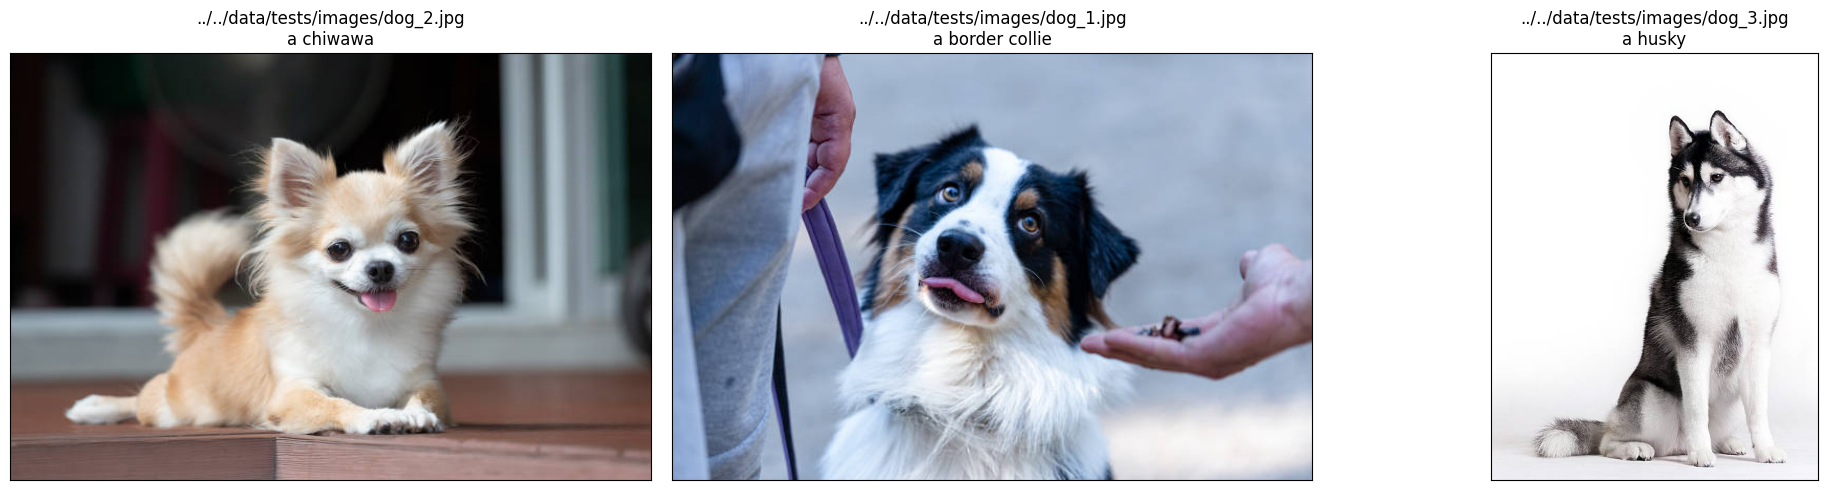

In [5]:
original_images = []
images = []
texts = []
plt.figure(figsize=(20,5))

for image_path in image_files:
    image = Image.open(image_path)

    plt.subplot(1,3,len(images)+1)
    plt.imshow(image)
    plt.title(f"{image_path}\n{descriptions[image_path.stem]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[image_path.stem])

plt.tight_layout()

### Calculer la similartié entre les images et le texte

In [6]:
image_input = torch.tensor(np.stack(images)).cpu()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cpu()

with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

Similarité cosinus

In [7]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

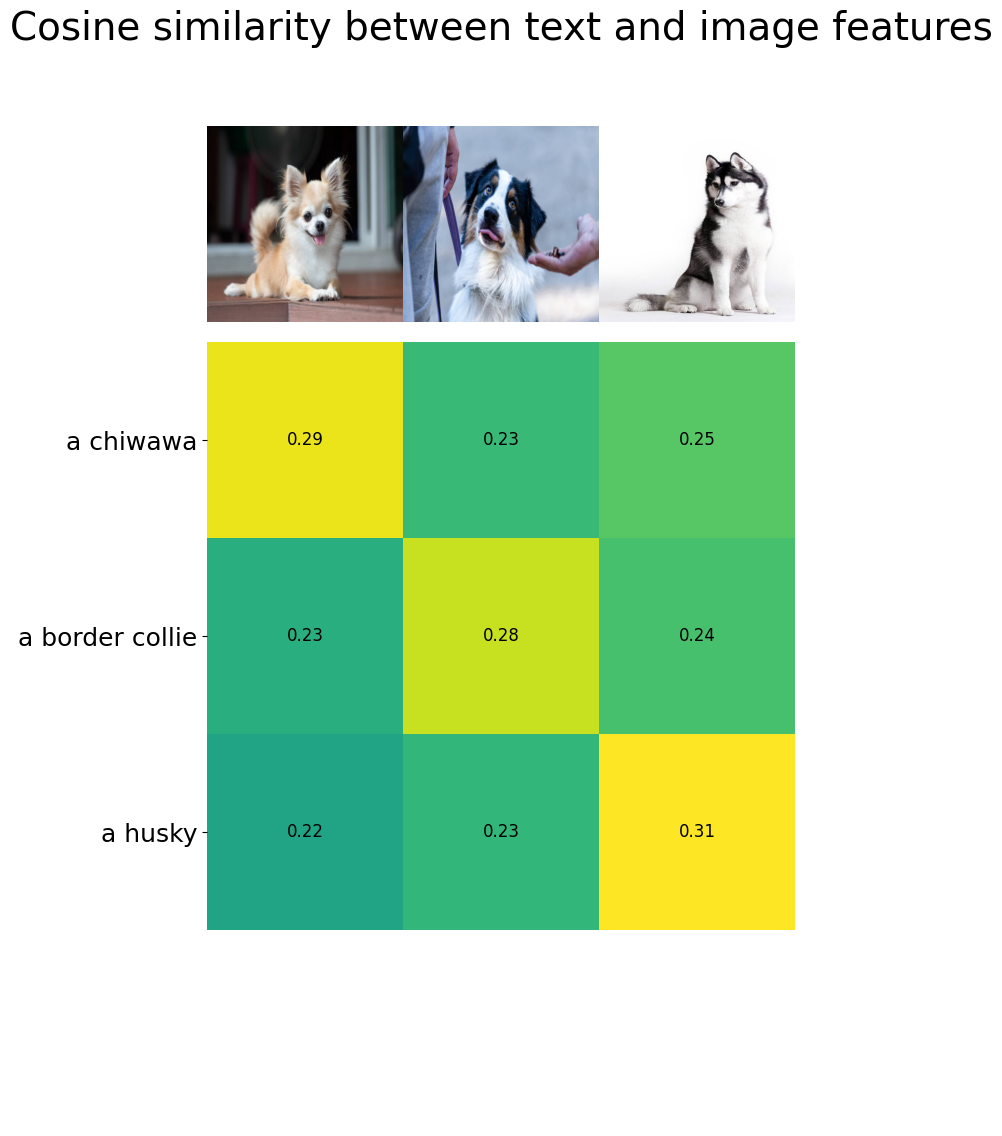

In [8]:
count = len(descriptions)

plt.figure(figsize=(20,14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)

plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")

for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x,y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=28)